In [1]:
import pandas as pd
import os
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import plotly.express as px

ANALYSIS_PATH = Path(os.getcwd())
ROOT_PATH = ANALYSIS_PATH.parent
SRC_PATH = ROOT_PATH.joinpath('src')
DATA_PATH = ROOT_PATH.joinpath('data')

In [2]:
all_data = pd.read_csv(DATA_PATH.joinpath("all_data_daily.csv"))
all_data['Date'] = pd.to_datetime(all_data['Date'])
all_data

,Date,Country,TotalLoadValue
0,2014-12-01,Austria,25801.2
1,2014-12-02,Austria,728087.6
2,2014-12-03,Austria,730588.8
3,2014-12-04,Austria,751961.6
4,2014-12-05,Austria,721206.8
...,...,...,...
56236,2021-05-28,United Kingdom,1551461.0
56237,2021-05-29,United Kingdom,1397079.0
56238,2021-05-30,United Kingdom,1293924.0
56239,2021-05-31,United Kingdom,1410300.0


## Feature Engineering

In [68]:
year = 365.2425

In [69]:
all_data["DayOfYear"] = all_data['Date'].apply(lambda x: int(x.dayofyear))
all_data["YearSin"] = np.sin(all_data['DayOfYear'] * (2 * np.pi / year))
all_data["YearCos"] = np.cos(all_data['DayOfYear'] * (2 * np.pi / year))
all_data["Year"] = all_data['Date'].apply(lambda x: int(x.year))

In [70]:
aus = all_data[all_data['Country']=="Austria"]
aus

,Date,Country,TotalLoadValue,DayOfYear,YearSin,YearCos,Year
0,2014-12-01,Austria,25801.2,335,-0.497101,0.867692,2014
1,2014-12-02,Austria,728087.6,336,-0.482102,0.876115,2014
2,2014-12-03,Austria,730588.8,337,-0.466960,0.884279,2014
3,2014-12-04,Austria,751961.6,338,-0.451679,0.892180,2014
4,2014-12-05,Austria,721206.8,339,-0.436265,0.899818,2014
...,...,...,...,...,...,...,...
2371,2021-05-29,Austria,567318.0,149,0.546667,-0.837350,2021
2372,2021-05-30,Austria,518176.4,150,0.532182,-0.846630,2021
2373,2021-05-31,Austria,655933.6,151,0.517540,-0.855659,2021
2374,2021-06-01,Austria,665577.6,152,0.502744,-0.864435,2021


In [72]:
aus.to_csv(DATA_PATH.joinpath("austria_fe_daily.csv"), index=False)

## Data Split

In [6]:
df = aus.drop(["Date", "Country"], axis=1)

column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

## Data Normalisation

In [7]:
train_mean = train_df.mean()
train_std = train_df.std()

In [8]:
train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

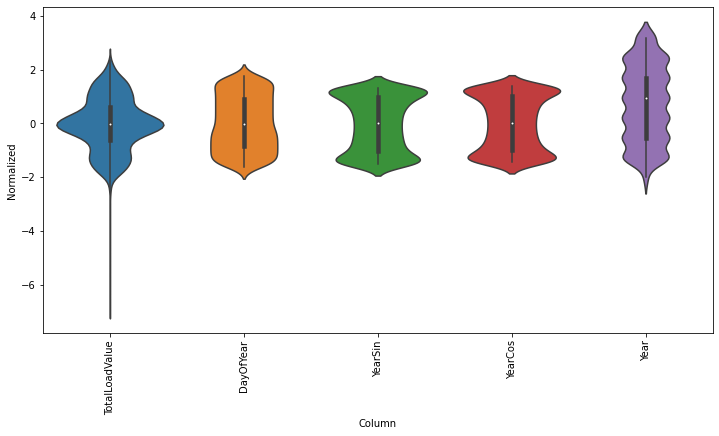

In [9]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

## Data Windowing

In [10]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

  def split_window(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
      labels = tf.stack(
          [labels[:, :, self.column_indices[name]] for name in self.label_columns],
          axis=-1)

    # Slicing doesn't preserve static shape information, so set the shapes
    # manually. This way the `tf.data.Datasets` are easier to inspect.
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])

    return inputs, labels

  def plot(self, model=None, plot_col='TotalLoadValue', max_subplots=3):
    inputs, labels = self.example
    plt.figure(figsize=(12, 8))
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))
    for n in range(max_n):
      plt.subplot(max_n, 1, n+1)
      plt.ylabel(f'{plot_col} [normed]')
      plt.plot(self.input_indices, inputs[n, :, plot_col_index],
              label='Inputs', marker='.', zorder=-10)

      if self.label_columns:
        label_col_index = self.label_columns_indices.get(plot_col, None)
      else:
        label_col_index = plot_col_index

      if label_col_index is None:
        continue

      plt.scatter(self.label_indices, labels[n, :, label_col_index],
                  edgecolors='k', label='Labels', c='#2ca02c', s=64)
      if model is not None:
        predictions = model(inputs)
        plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                    marker='X', edgecolors='k', label='Predictions',
                    c='#ff7f0e', s=64)

      if n == 0:
        plt.legend()

    plt.xlabel('Time [d]')

  def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.utils.timeseries_dataset_from_array(
        data=data,
        targets=None,
        sequence_length=self.total_window_size,
        sequence_stride=1,
        shuffle=True,
        batch_size=32,)

    ds = ds.map(self.split_window)

    return ds

  @property
  def train(self):
    return self.make_dataset(self.train_df)

  @property
  def val(self):
    return self.make_dataset(self.val_df)

  @property
  def test(self):
    return self.make_dataset(self.test_df)

  @property
  def example(self):
    """Get and cache an example batch of `inputs, labels` for plotting."""
    result = getattr(self, '_example', None)
    if result is None:
      # No example batch was found, so get one from the `.train` dataset
      result = next(iter(self.train))
      # And cache it for next time
      self._example = result
    return result


In [11]:
w1 = WindowGenerator(input_width=20, label_width=1, shift=1,
                     label_columns=['TotalLoadValue'])
w1

Total window size: 21
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
Label indices: [20]
Label column name(s): ['TotalLoadValue']

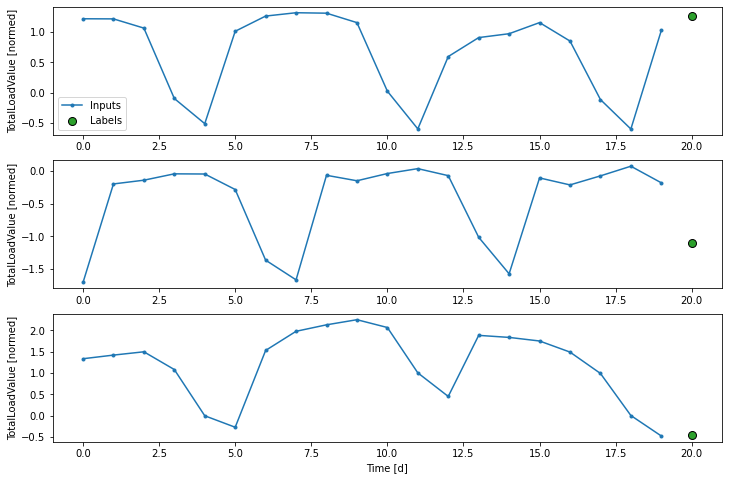

In [12]:
w1.plot()

## Single Step Model

In [13]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['TotalLoadValue'])
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['TotalLoadValue']

In [14]:
for example_inputs, example_labels in single_step_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 1, 5)
Labels shape (batch, time, features): (32, 1, 1)


In [15]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

In [16]:
baseline = Baseline(label_index=column_indices['TotalLoadValue'])

baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                 metrics=[tf.keras.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

15/15 [==============================] - 0s 3ms/step - loss: 0.5113 - mean_absolute_error: 0.4979


In [17]:
wide_window = WindowGenerator(
    input_width=20, label_width=20, shift=1,
    label_columns=['TotalLoadValue'])

wide_window

Total window size: 21
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]
Label column name(s): ['TotalLoadValue']

In [18]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 20, 5)
Output shape: (32, 20, 1)


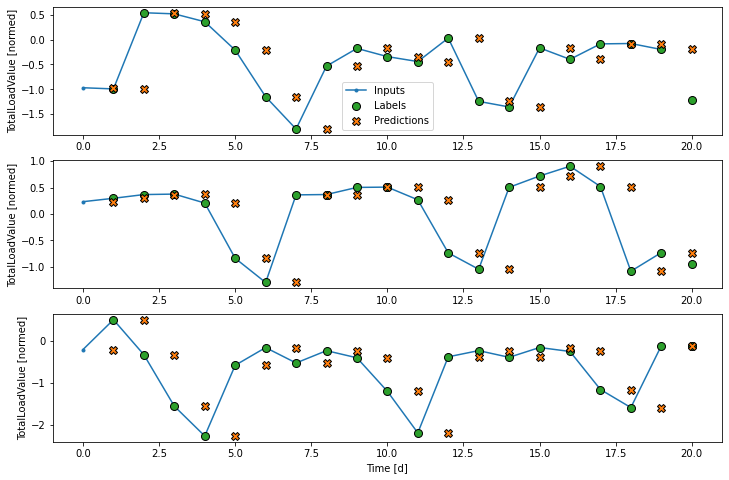

In [19]:
wide_window.plot(baseline)


#### Linear Model

In [20]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])
print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', linear(single_step_window.example[0]).shape)

Input shape: (32, 1, 5)
Output shape: (32, 1, 1)


In [21]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

In [22]:
history = compile_and_fit(linear, single_step_window)

val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)

Epoch 1/20
52/52 [==============================] - 1s 8ms/step - loss: 1.4120 - mean_absolute_error: 0.9697 - val_loss: 1.4152 - val_mean_absolute_error: 0.9950
Epoch 2/20
52/52 [==============================] - 0s 5ms/step - loss: 1.2344 - mean_absolute_error: 0.8992 - val_loss: 1.2359 - val_mean_absolute_error: 0.9262
Epoch 3/20
52/52 [==============================] - 0s 4ms/step - loss: 1.0878 - mean_absolute_error: 0.8379 - val_loss: 1.0838 - val_mean_absolute_error: 0.8627
Epoch 4/20
52/52 [==============================] - 0s 4ms/step - loss: 0.9688 - mean_absolute_error: 0.7866 - val_loss: 0.9582 - val_mean_absolute_error: 0.8066
Epoch 5/20
52/52 [==============================] - 0s 4ms/step - loss: 0.8713 - mean_absolute_error: 0.7440 - val_loss: 0.8553 - val_mean_absolute_error: 0.7606
Epoch 6/20
52/52 [==============================] - 0s 4ms/step - loss: 0.7939 - mean_absolute_error: 0.7114 - val_loss: 0.7679 - val_mean_absolute_error: 0.7251
Epoch 7/20
52/52 [==========

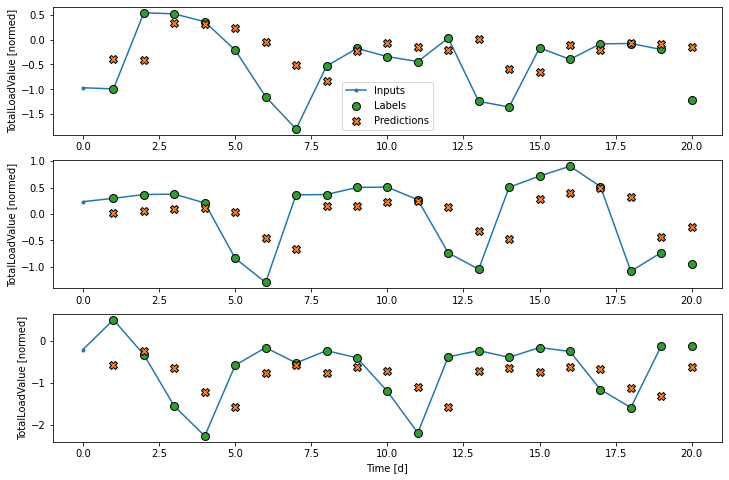

In [23]:
wide_window.plot(linear)

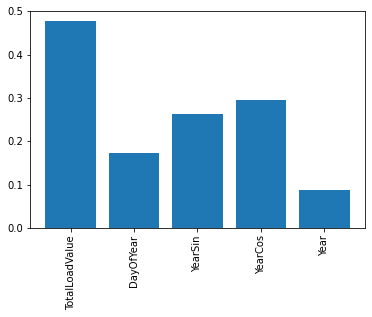

In [24]:
plt.bar(x = range(len(train_df.columns)),
        height=linear.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_df.columns)))
_ = axis.set_xticklabels(train_df.columns, rotation=90)

### Dense Model

In [25]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

Epoch 1/20
52/52 [==============================] - 2s 9ms/step - loss: 0.5416 - mean_absolute_error: 0.5915 - val_loss: 0.4386 - val_mean_absolute_error: 0.5112
Epoch 2/20
52/52 [==============================] - 0s 4ms/step - loss: 0.4524 - mean_absolute_error: 0.5495 - val_loss: 0.4311 - val_mean_absolute_error: 0.4976
Epoch 3/20
52/52 [==============================] - 0s 4ms/step - loss: 0.4341 - mean_absolute_error: 0.5376 - val_loss: 0.4593 - val_mean_absolute_error: 0.4993
Epoch 4/20
52/52 [==============================] - 0s 4ms/step - loss: 0.4273 - mean_absolute_error: 0.5267 - val_loss: 0.4155 - val_mean_absolute_error: 0.4953
Epoch 5/20
52/52 [==============================] - 0s 4ms/step - loss: 0.4166 - mean_absolute_error: 0.5211 - val_loss: 0.4003 - val_mean_absolute_error: 0.4938
Epoch 6/20
52/52 [==============================] - 0s 4ms/step - loss: 0.4089 - mean_absolute_error: 0.5148 - val_loss: 0.3936 - val_mean_absolute_error: 0.4984
Epoch 7/20
52/52 [==========

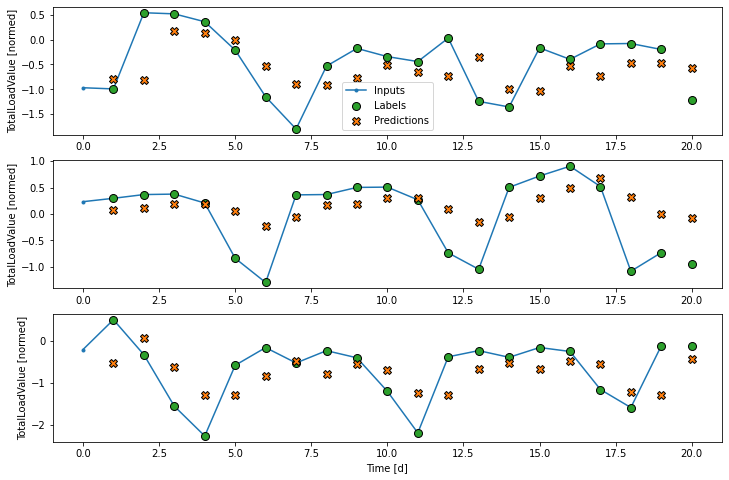

In [26]:
wide_window.plot(dense)

### Multi-Step dense

In [27]:
CONV_WIDTH = 30
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=['TotalLoadValue'])

conv_window

Total window size: 31
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
Label indices: [30]
Label column name(s): ['TotalLoadValue']

Text(0.5, 1.0, 'Given 10 days of inputs, predict 1 day into the future.')

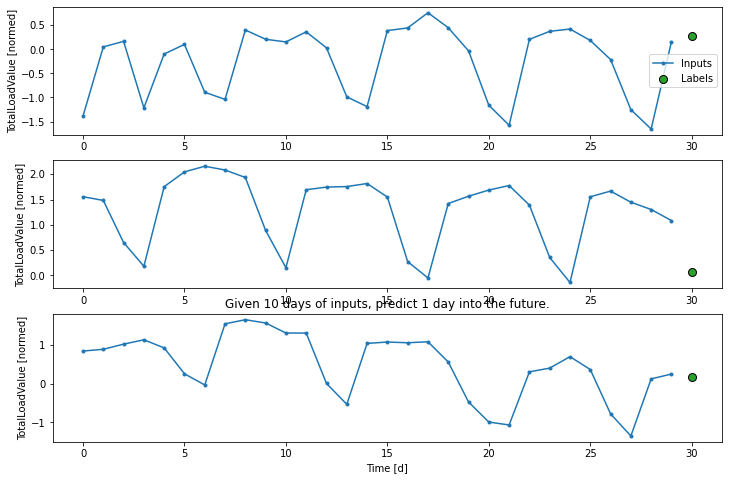

In [28]:
conv_window.plot()
plt.title("Given 10 days of inputs, predict 1 day into the future.")

In [29]:
multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])

print('Input shape:', conv_window.example[0].shape)
print('Output shape:', multi_step_dense(conv_window.example[0]).shape)

Input shape: (32, 30, 5)
Output shape: (32, 1, 1)


In [30]:
history = compile_and_fit(multi_step_dense, conv_window)

Epoch 1/20
52/52 [==============================] - 1s 9ms/step - loss: 0.5270 - mean_absolute_error: 0.5458 - val_loss: 0.2555 - val_mean_absolute_error: 0.3993
Epoch 2/20
52/52 [==============================] - 0s 4ms/step - loss: 0.2697 - mean_absolute_error: 0.3722 - val_loss: 0.2501 - val_mean_absolute_error: 0.3763
Epoch 3/20
52/52 [==============================] - 0s 4ms/step - loss: 0.2254 - mean_absolute_error: 0.3308 - val_loss: 0.3390 - val_mean_absolute_error: 0.4288
Epoch 4/20
52/52 [==============================] - 0s 4ms/step - loss: 0.2058 - mean_absolute_error: 0.3120 - val_loss: 0.2564 - val_mean_absolute_error: 0.3640


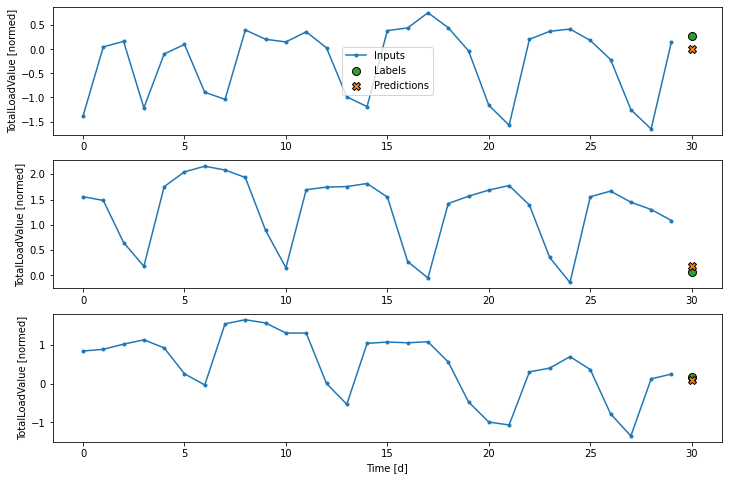

In [31]:
conv_window.plot(multi_step_dense)

### CNN

In [32]:
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])
print("Conv model on `conv_window`")
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', conv_model(conv_window.example[0]).shape)

Conv model on `conv_window`
Input shape: (32, 30, 5)
Output shape: (32, 1, 1)


In [51]:
conv_window.train.batch(32)

<BatchDataset element_spec=(TensorSpec(shape=(None, None, 30, 5), dtype=tf.float32, name=None), TensorSpec(shape=(None, None, 1, 1), dtype=tf.float32, name=None))>

In [46]:
dir(conv_window.train)

['_GeneratorState',
 '__abstractmethods__',
 '__annotations__',
 '__bool__',
 '__class__',
 '__class_getitem__',
 '__debug_string__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__nonzero__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '__tf_tracing_type__',
 '__weakref__',
 '_abc_impl',
 '_add_trackable_child',
 '_add_variable_with_custom_getter',
 '_apply_debug_options',
 '_as_serialized_graph',
 '_checkpoint_dependencies',
 '_common_args',
 '_consumers',
 '_deferred_dependencies',
 '_deserialization_dependencies',
 '_deserialize_from_proto',
 '_export_to_saved_model_graph',
 '_flat_shapes',
 '_flat_structure',
 '_flat_types',
 '_functions',
 '_gather_saveables_for_checkpoint',
 '_get_legacy_sav

In [33]:
history = compile_and_fit(conv_model, conv_window)

val_performance['Conv'] = conv_model.evaluate(conv_window.val)
performance['Conv'] = conv_model.evaluate(conv_window.test, verbose=0)

Epoch 1/20
52/52 [==============================] - 2s 13ms/step - loss: 0.4504 - mean_absolute_error: 0.5191 - val_loss: 0.2057 - val_mean_absolute_error: 0.3503
Epoch 2/20
52/52 [==============================] - 0s 5ms/step - loss: 0.2203 - mean_absolute_error: 0.3197 - val_loss: 0.1695 - val_mean_absolute_error: 0.2972
Epoch 3/20
52/52 [==============================] - 0s 4ms/step - loss: 0.1876 - mean_absolute_error: 0.2784 - val_loss: 0.1431 - val_mean_absolute_error: 0.2747
Epoch 4/20
52/52 [==============================] - 0s 4ms/step - loss: 0.1739 - mean_absolute_error: 0.2672 - val_loss: 0.1375 - val_mean_absolute_error: 0.2570
Epoch 5/20
52/52 [==============================] - 0s 4ms/step - loss: 0.1616 - mean_absolute_error: 0.2550 - val_loss: 0.1233 - val_mean_absolute_error: 0.2521
Epoch 6/20
52/52 [==============================] - 0s 4ms/step - loss: 0.1566 - mean_absolute_error: 0.2538 - val_loss: 0.2129 - val_mean_absolute_error: 0.3645
Epoch 7/20
14/14 [=========

In [34]:
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=['TotalLoadValue'])

wide_conv_window

Total window size: 54
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52]
Label indices: [30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53]
Label column name(s): ['TotalLoadValue']

In [35]:
print("Wide conv window")
print('Input shape:', wide_conv_window.example[0].shape)
print('Labels shape:', wide_conv_window.example[1].shape)
print('Output shape:', conv_model(wide_conv_window.example[0]).shape)

Wide conv window
Input shape: (32, 53, 5)
Labels shape: (32, 24, 1)
Output shape: (32, 24, 1)


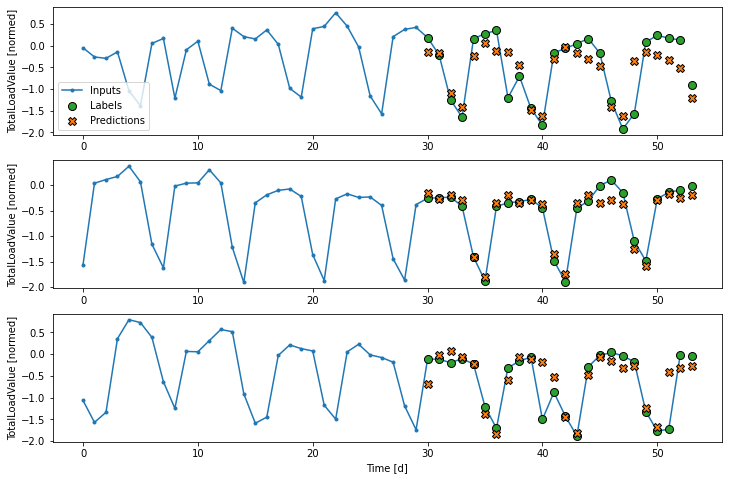

In [36]:
wide_conv_window.plot(conv_model)

## RNN/LSTM

In [53]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', lstm_model(wide_window.example[0]).shape)

Input shape: (32, 20, 5)
Output shape: (32, 20, 1)


In [54]:
history = compile_and_fit(lstm_model, wide_window)

val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

Epoch 1/20
52/52 [==============================] - 5s 28ms/step - loss: 0.6958 - mean_absolute_error: 0.6780 - val_loss: 0.6261 - val_mean_absolute_error: 0.5867
Epoch 2/20
52/52 [==============================] - 1s 13ms/step - loss: 0.5635 - mean_absolute_error: 0.6305 - val_loss: 0.6055 - val_mean_absolute_error: 0.5872
Epoch 3/20
52/52 [==============================] - 1s 13ms/step - loss: 0.5312 - mean_absolute_error: 0.6147 - val_loss: 0.5683 - val_mean_absolute_error: 0.5759
Epoch 4/20
52/52 [==============================] - 1s 13ms/step - loss: 0.4899 - mean_absolute_error: 0.5882 - val_loss: 0.5358 - val_mean_absolute_error: 0.5554
Epoch 5/20
52/52 [==============================] - 1s 14ms/step - loss: 0.4266 - mean_absolute_error: 0.5374 - val_loss: 0.4853 - val_mean_absolute_error: 0.5282
Epoch 6/20
52/52 [==============================] - 1s 13ms/step - loss: 0.3538 - mean_absolute_error: 0.4724 - val_loss: 0.4013 - val_mean_absolute_error: 0.4851
Epoch 7/20
52/52 [====

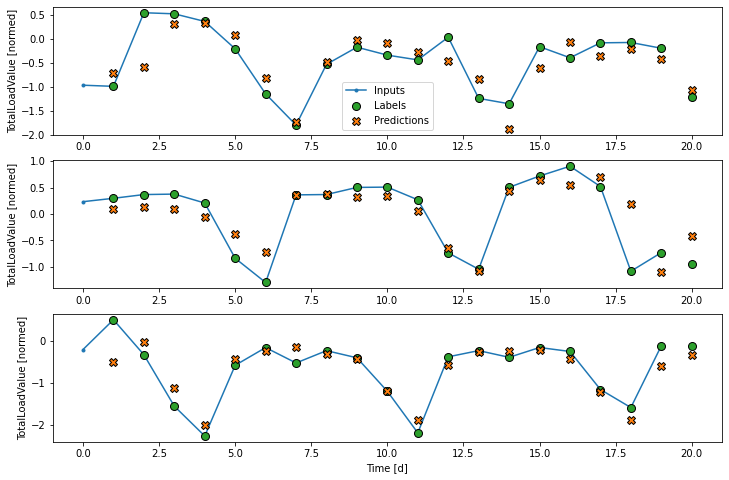

In [55]:
wide_window.plot(lstm_model)

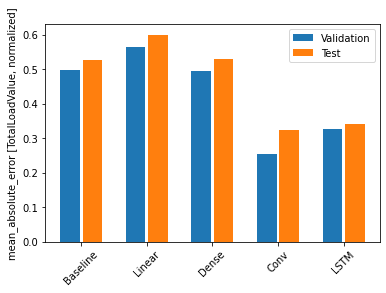

In [57]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [TotalLoadValue, normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()

## MULTI STEP

Total window size: 60
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
Label indices: [30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53
 54 55 56 57 58 59]
Label column name(s): None

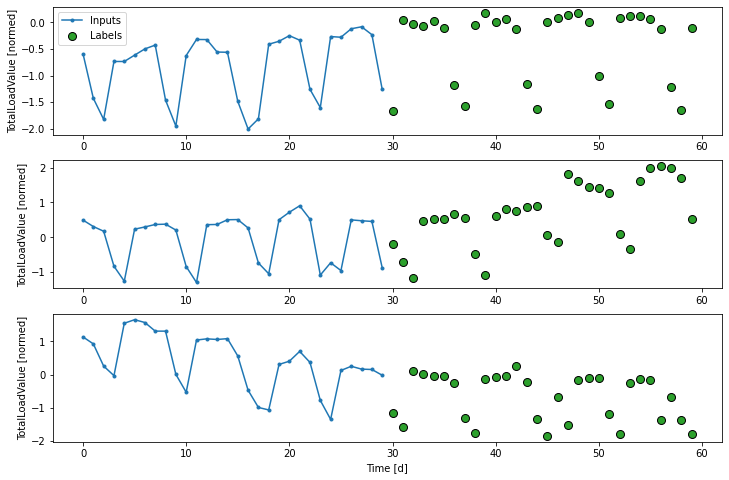

In [59]:
OUT_STEPS = 30
multi_window = WindowGenerator(input_width=30,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

multi_window.plot()
multi_window

13/13 [==============================] - 0s 2ms/step - loss: 0.3303 - mean_absolute_error: 0.3116


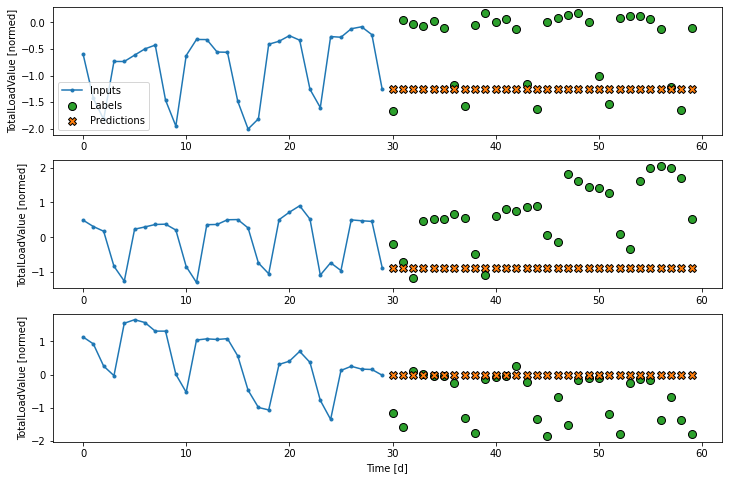

In [60]:
class MultiStepLastBaseline(tf.keras.Model):
  def call(self, inputs):
    return tf.tile(inputs[:, -1:, :], [1, OUT_STEPS, 1])

last_baseline = MultiStepLastBaseline()
last_baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                      metrics=[tf.keras.metrics.MeanAbsoluteError()])

multi_val_performance = {}
multi_performance = {}

multi_val_performance['Last'] = last_baseline.evaluate(multi_window.val)
multi_performance['Last'] = last_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(last_baseline)

13/13 [==============================] - 0s 3ms/step - loss: 0.5497 - mean_absolute_error: 0.4891


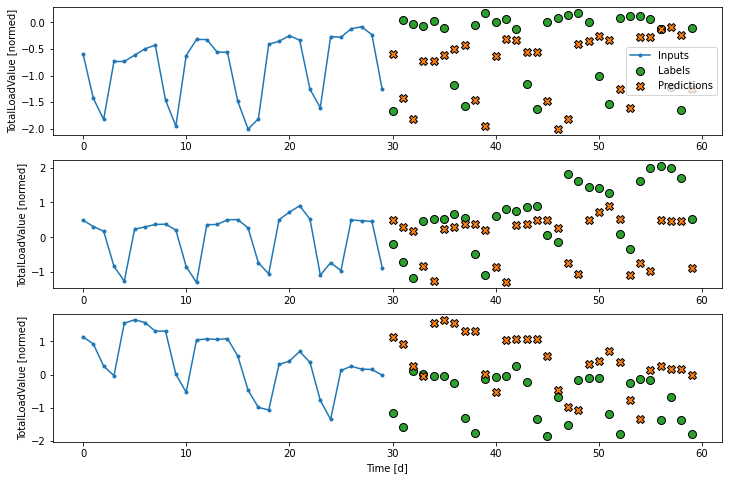

In [61]:
class RepeatBaseline(tf.keras.Model):
  def call(self, inputs):
    return inputs

repeat_baseline = RepeatBaseline()
repeat_baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                        metrics=[tf.keras.metrics.MeanAbsoluteError()])

multi_val_performance['Repeat'] = repeat_baseline.evaluate(multi_window.val)
multi_performance['Repeat'] = repeat_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(repeat_baseline)

Epoch 1/20
51/51 [==============================] - 1s 9ms/step - loss: 0.8963 - mean_absolute_error: 0.8144 - val_loss: 1.5609 - val_mean_absolute_error: 1.0466
Epoch 2/20
51/51 [==============================] - 0s 4ms/step - loss: 0.7604 - mean_absolute_error: 0.7431 - val_loss: 1.3905 - val_mean_absolute_error: 0.9757
Epoch 3/20
51/51 [==============================] - 0s 4ms/step - loss: 0.6553 - mean_absolute_error: 0.6822 - val_loss: 1.2432 - val_mean_absolute_error: 0.9100
Epoch 4/20
51/51 [==============================] - 0s 4ms/step - loss: 0.5722 - mean_absolute_error: 0.6297 - val_loss: 1.1140 - val_mean_absolute_error: 0.8502
Epoch 5/20
51/51 [==============================] - 0s 4ms/step - loss: 0.5052 - mean_absolute_error: 0.5839 - val_loss: 1.0011 - val_mean_absolute_error: 0.7954
Epoch 6/20
51/51 [==============================] - 0s 4ms/step - loss: 0.4509 - mean_absolute_error: 0.5438 - val_loss: 0.9009 - val_mean_absolute_error: 0.7457
Epoch 7/20
51/51 [==========

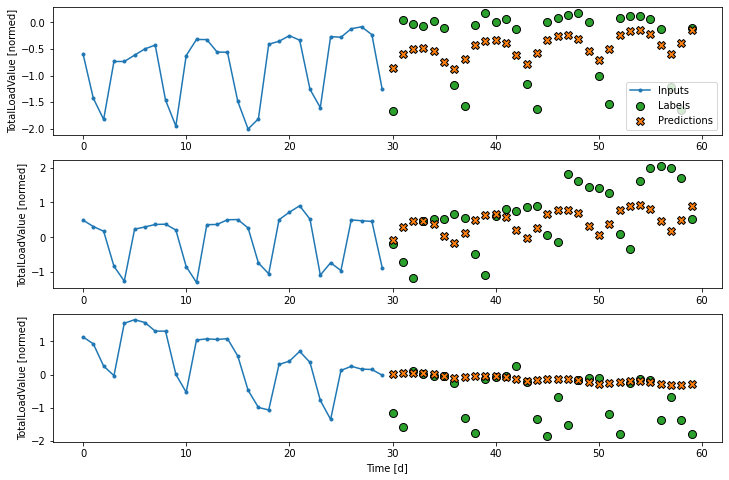

In [62]:
multi_linear_model = tf.keras.Sequential([
    # Take the last time-step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_linear_model, multi_window)

multi_val_performance['Linear'] = multi_linear_model.evaluate(multi_window.val)
multi_performance['Linear'] = multi_linear_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_linear_model)

Epoch 1/20
51/51 [==============================] - 2s 12ms/step - loss: 0.4467 - mean_absolute_error: 0.5077 - val_loss: 0.2324 - val_mean_absolute_error: 0.2924
Epoch 2/20
51/51 [==============================] - 0s 6ms/step - loss: 0.1629 - mean_absolute_error: 0.2141 - val_loss: 0.2024 - val_mean_absolute_error: 0.2255
Epoch 3/20
51/51 [==============================] - 0s 6ms/step - loss: 0.1486 - mean_absolute_error: 0.1895 - val_loss: 0.1853 - val_mean_absolute_error: 0.2126
Epoch 4/20
51/51 [==============================] - 0s 5ms/step - loss: 0.1425 - mean_absolute_error: 0.1801 - val_loss: 0.1800 - val_mean_absolute_error: 0.2097
Epoch 5/20
51/51 [==============================] - 0s 5ms/step - loss: 0.1381 - mean_absolute_error: 0.1761 - val_loss: 0.1649 - val_mean_absolute_error: 0.1959
Epoch 6/20
51/51 [==============================] - 0s 6ms/step - loss: 0.1346 - mean_absolute_error: 0.1724 - val_loss: 0.1679 - val_mean_absolute_error: 0.1959
Epoch 7/20
51/51 [=========

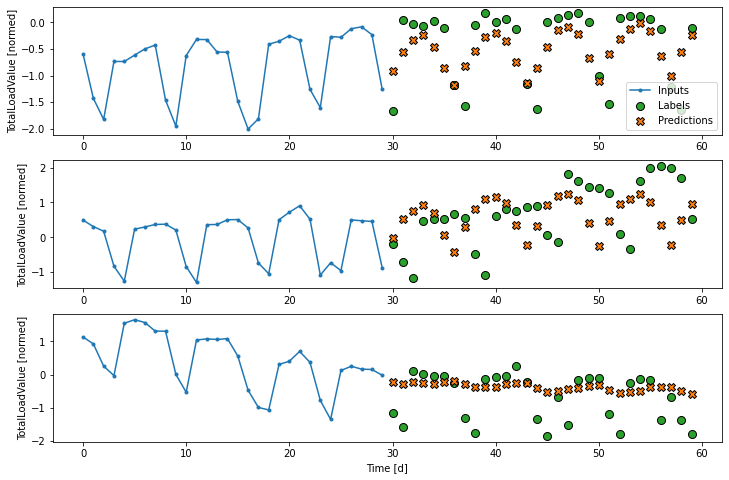

In [63]:
multi_dense_model = tf.keras.Sequential([
    # Take the last time step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, dense_units]
    tf.keras.layers.Dense(512, activation='relu'),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_dense_model, multi_window)

multi_val_performance['Dense'] = multi_dense_model.evaluate(multi_window.val)
multi_performance['Dense'] = multi_dense_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_dense_model)

Epoch 1/20
51/51 [==============================] - 1s 10ms/step - loss: 0.4776 - mean_absolute_error: 0.5326 - val_loss: 0.2445 - val_mean_absolute_error: 0.3339
Epoch 2/20
51/51 [==============================] - 0s 5ms/step - loss: 0.1697 - mean_absolute_error: 0.2300 - val_loss: 0.1885 - val_mean_absolute_error: 0.2251
Epoch 3/20
51/51 [==============================] - 0s 5ms/step - loss: 0.1421 - mean_absolute_error: 0.1924 - val_loss: 0.1651 - val_mean_absolute_error: 0.2034
Epoch 4/20
51/51 [==============================] - 0s 5ms/step - loss: 0.1286 - mean_absolute_error: 0.1748 - val_loss: 0.1612 - val_mean_absolute_error: 0.2010
Epoch 5/20
51/51 [==============================] - 0s 5ms/step - loss: 0.1221 - mean_absolute_error: 0.1677 - val_loss: 0.1473 - val_mean_absolute_error: 0.1874
Epoch 6/20
51/51 [==============================] - 0s 5ms/step - loss: 0.1177 - mean_absolute_error: 0.1625 - val_loss: 0.1376 - val_mean_absolute_error: 0.1831
Epoch 7/20
51/51 [=========

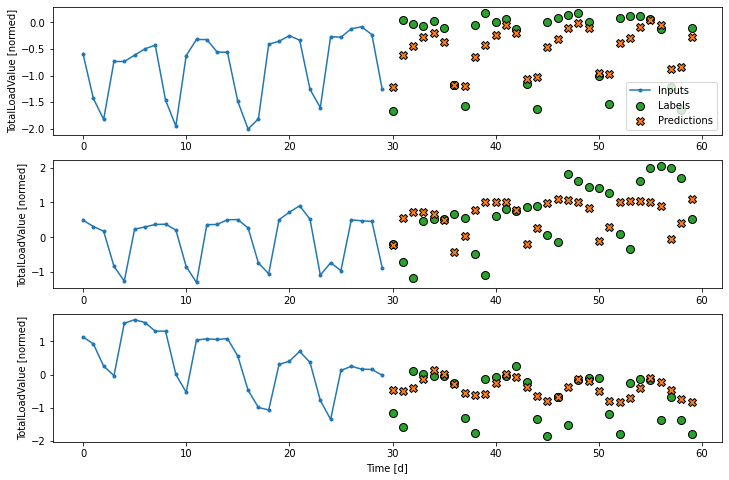

In [64]:
CONV_WIDTH = 3
multi_conv_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_conv_model, multi_window)

multi_val_performance['Conv'] = multi_conv_model.evaluate(multi_window.val)
multi_performance['Conv'] = multi_conv_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_conv_model)

Epoch 1/20
51/51 [==============================] - 6s 33ms/step - loss: 0.7742 - mean_absolute_error: 0.7447 - val_loss: 1.2987 - val_mean_absolute_error: 0.8847
Epoch 2/20
51/51 [==============================] - 1s 17ms/step - loss: 0.4034 - mean_absolute_error: 0.4964 - val_loss: 0.9534 - val_mean_absolute_error: 0.7477
Epoch 3/20
51/51 [==============================] - 1s 18ms/step - loss: 0.2544 - mean_absolute_error: 0.3667 - val_loss: 0.5920 - val_mean_absolute_error: 0.6278
Epoch 4/20
51/51 [==============================] - 1s 19ms/step - loss: 0.1903 - mean_absolute_error: 0.2941 - val_loss: 0.4366 - val_mean_absolute_error: 0.5335
Epoch 5/20
51/51 [==============================] - 1s 20ms/step - loss: 0.1710 - mean_absolute_error: 0.2617 - val_loss: 0.3816 - val_mean_absolute_error: 0.4897
Epoch 6/20
51/51 [==============================] - 1s 19ms/step - loss: 0.1597 - mean_absolute_error: 0.2400 - val_loss: 0.3449 - val_mean_absolute_error: 0.4557
Epoch 7/20
51/51 [====

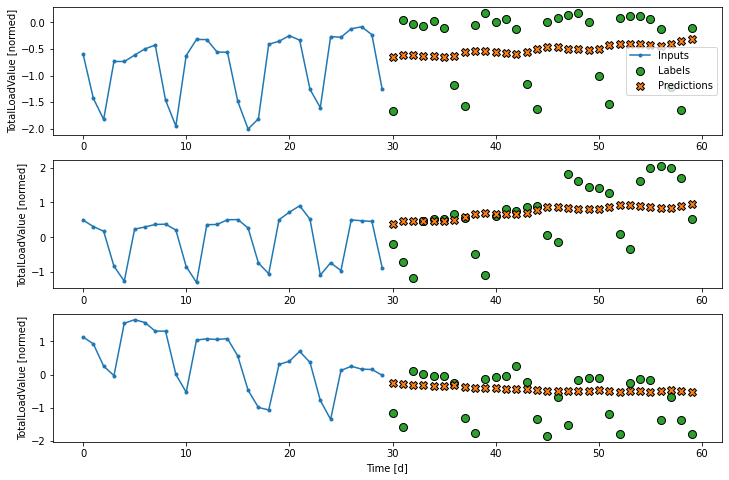

In [65]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, multi_window)

multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_lstm_model)